Explarational data analysis dump

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))


In [2]:
import pandas as pd
import polars as pl
import networkx as nx
import matplotlib.pyplot as plt
from utils import gpn


In [3]:
all_graphs_upto9n_df = (
    pd.read_csv(r"../../data/generated/all_graphs_9n.csv")
    .assign(max_gpn=lambda df: df.groupby('num_nodes')['gpn_num'].transform('max'))
    .query('gpn_num == max_gpn')
    .drop(columns=['max_gpn', 'num_edges'])
    .sort_values(["num_nodes"])
)
all_graphs_upto9n_df


,graph6_encoding,num_nodes,gpn_num
0,@,1,1
1,A_,2,3
2,BW,3,6
3,Bw,3,6
7,C],4,12
16,DFw,5,20
101,EFz_,6,33
340,F?zv_,7,49
353,F?~v_,7,49
5412,G?zVf_,8,74


In [4]:
graph_class_df = (
    pd.read_csv(r"../../data/generated/gpn_class_data.csv")
    .assign(max_gpn=lambda df: df.groupby('num_nodes')['gpn_num'].transform('max'))
    .query('gpn_num == max_gpn')
    .drop(columns=['max_gpn', 'num_edges'])
    .sort_values(["num_nodes"])
    # .to_csv("../../data/generated/opt_gpn_graphs.csv", index=False)
)
graph_class_df


,graph6_encoding,type,num_nodes,gpn_num
0,@,bipartite,1,1
5043,@,triangle-free,1,1
1,A_,bipartite,2,3
5044,A_,triangle-free,2,3
5045,BW,triangle-free,3,6
2,BW,bipartite,3,6
5,C],bipartite,4,12
5048,C],triangle-free,4,12
5052,DFw,triangle-free,5,20
9,DFw,bipartite,5,20


In [5]:
all_graphs_10n_df = (
    pl.scan_csv("../gpn_values_n10.csv")
    .filter(pl.col('gpn_num') == pl.col('gpn_num').max())
    .collect()
)

print(all_graphs_10n_df)


shape: (1, 2)
┌───────────┬─────────┐
│ id        ┆ gpn_num │
│ ---       ┆ ---     │
│ str       ┆ i64     │
╞═══════════╪═════════╡
│ I?BvUqw}? ┆ 151     │
└───────────┴─────────┘


In [6]:
opt_graphs = []

for graph in all_graphs_upto9n_df["graph6_encoding"]: 
        opt_graphs.append(graph)

for graph in all_graphs_10n_df["id"]:
        opt_graphs.append(graph)


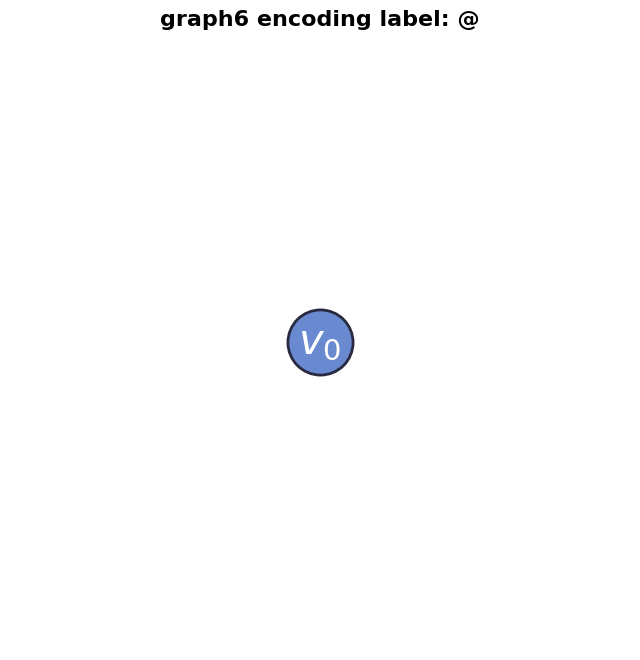

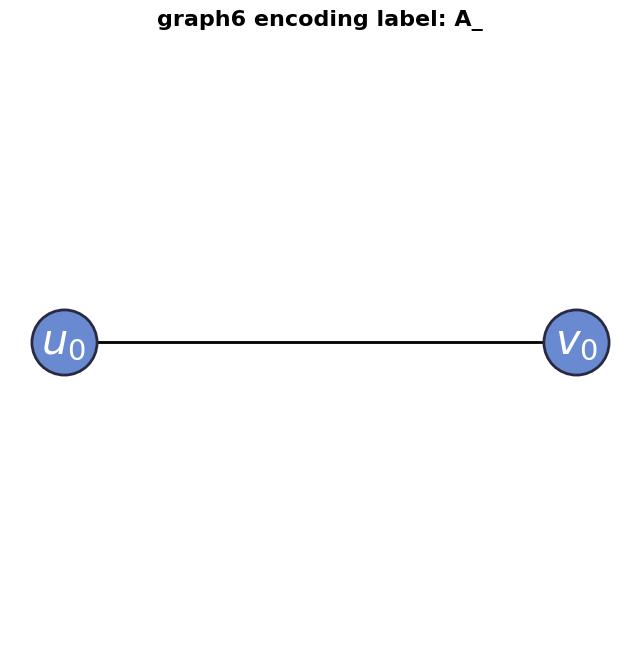

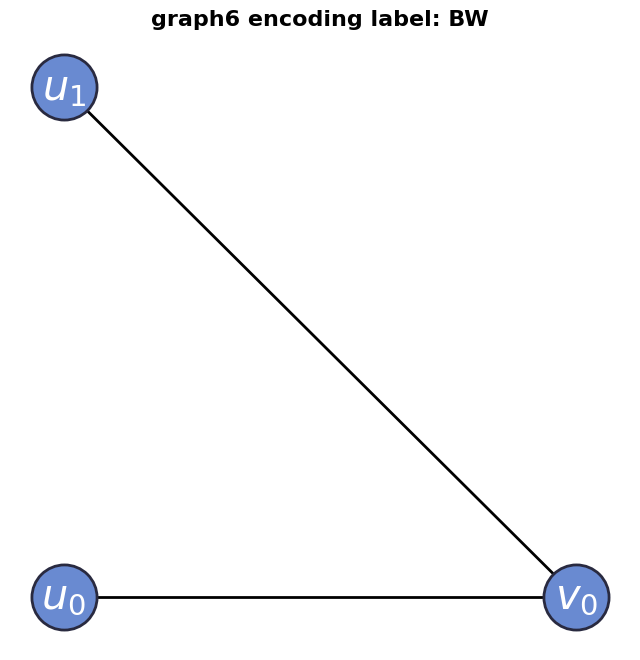

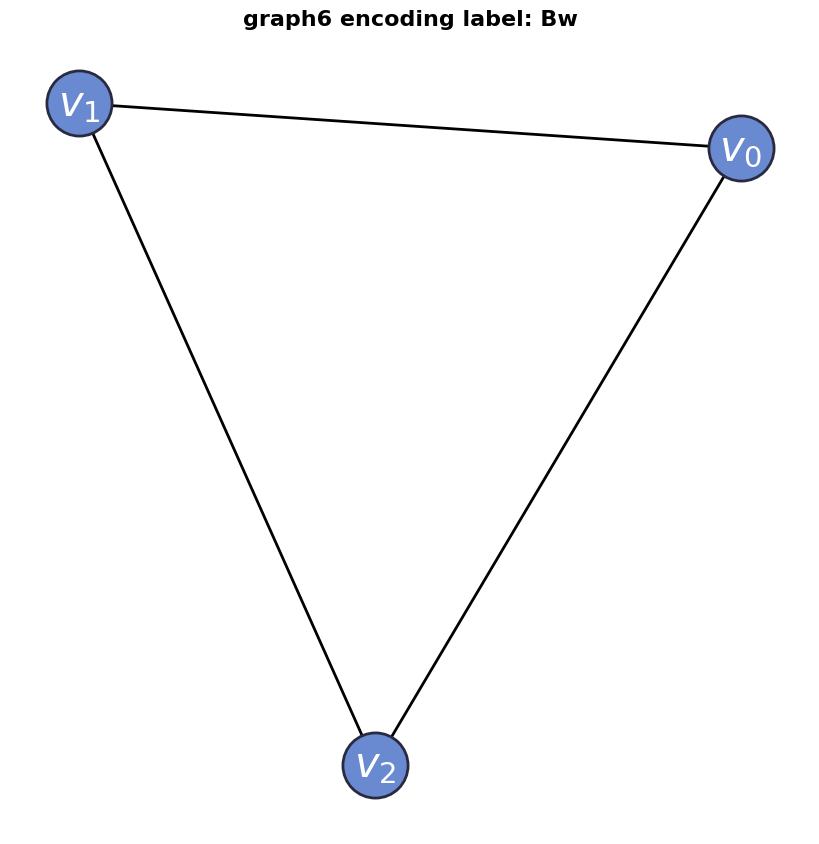

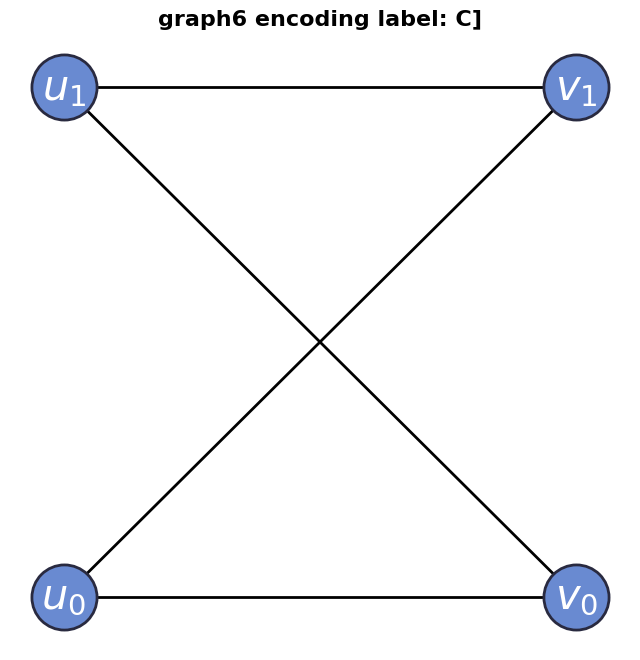

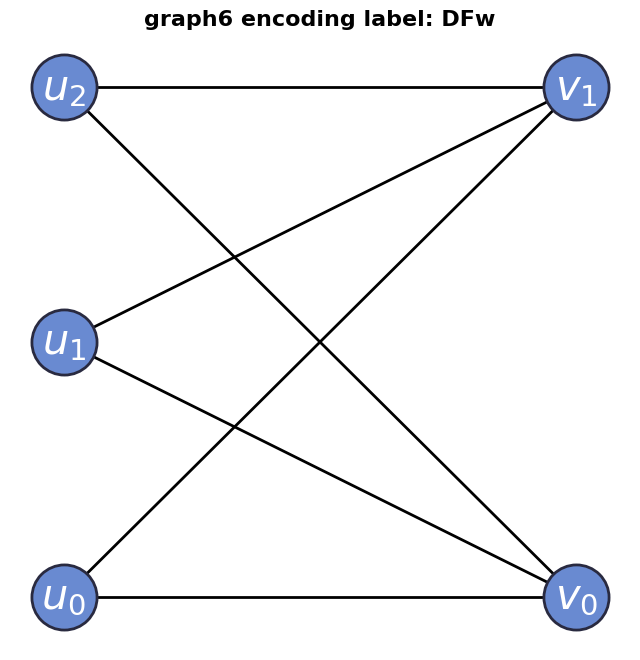

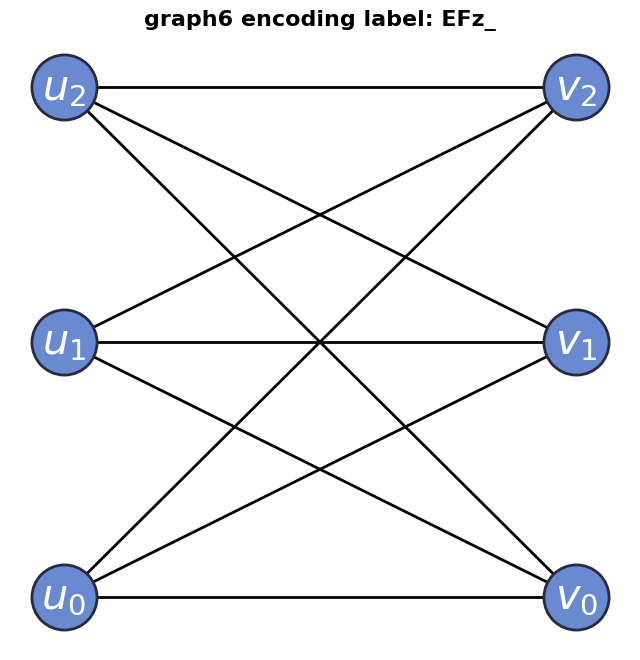

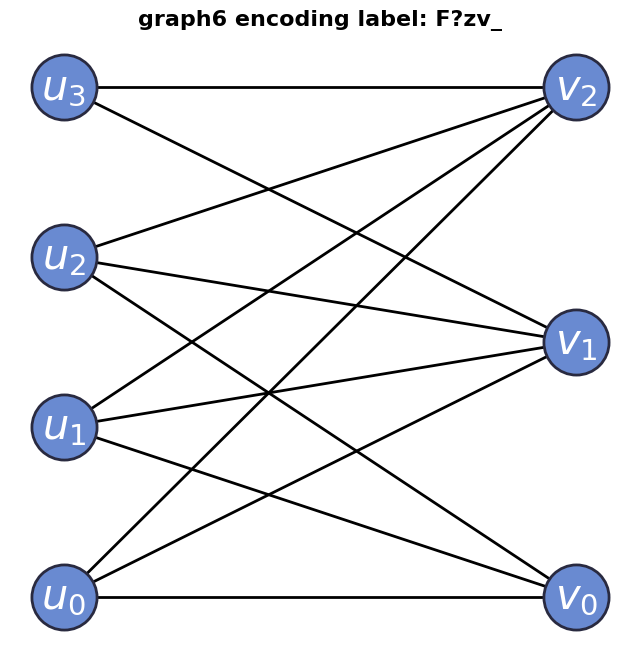

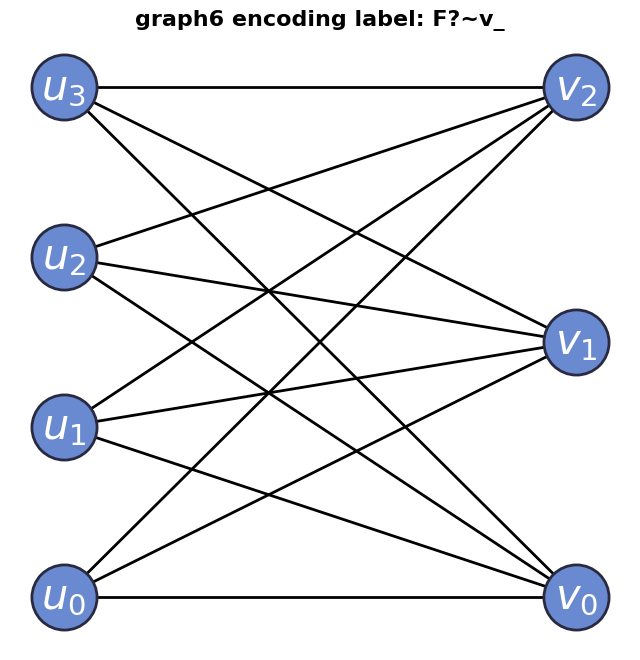

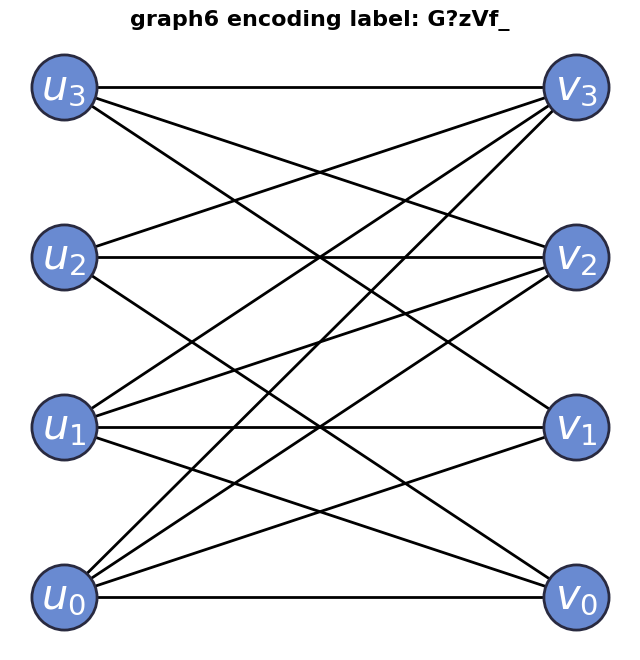

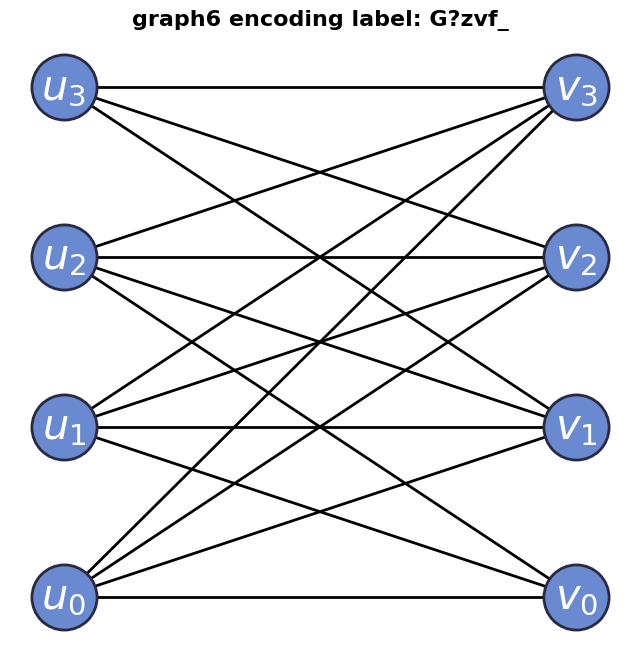

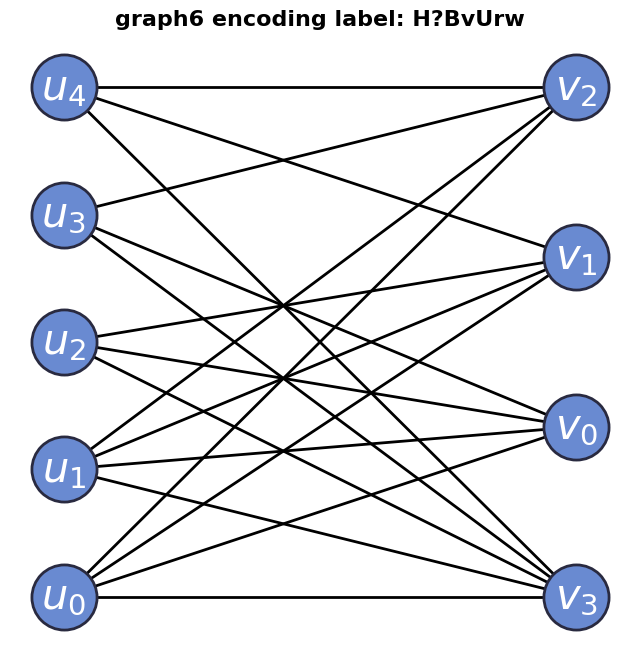

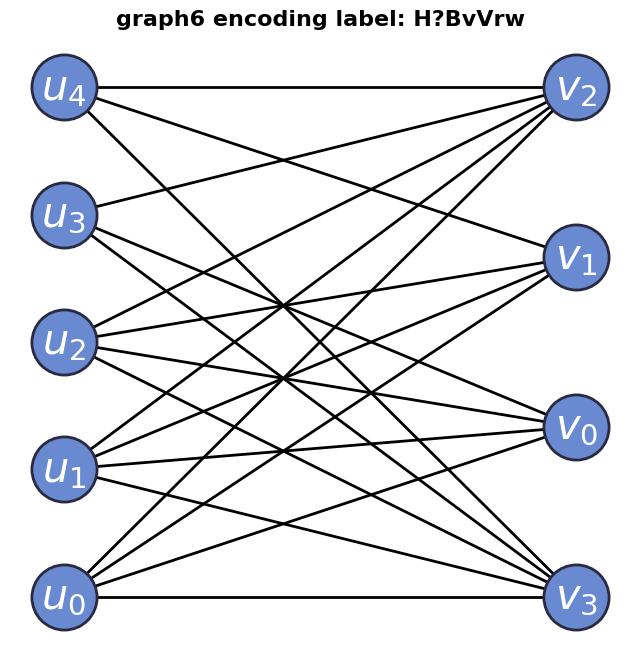

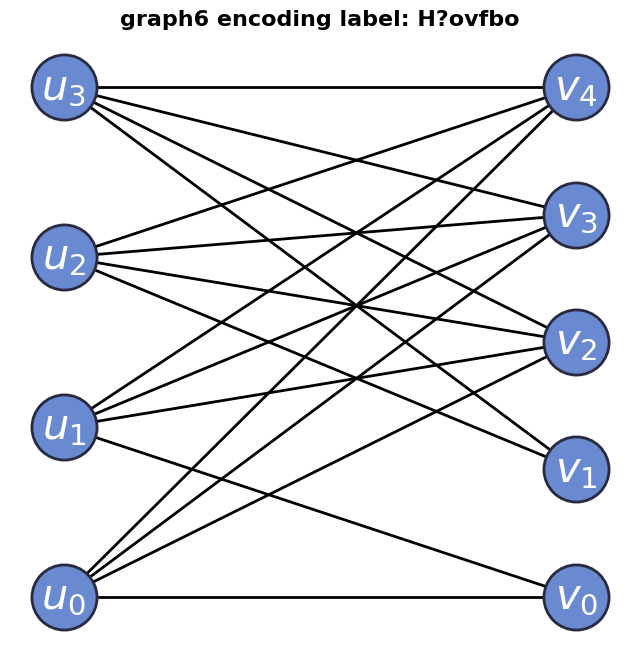

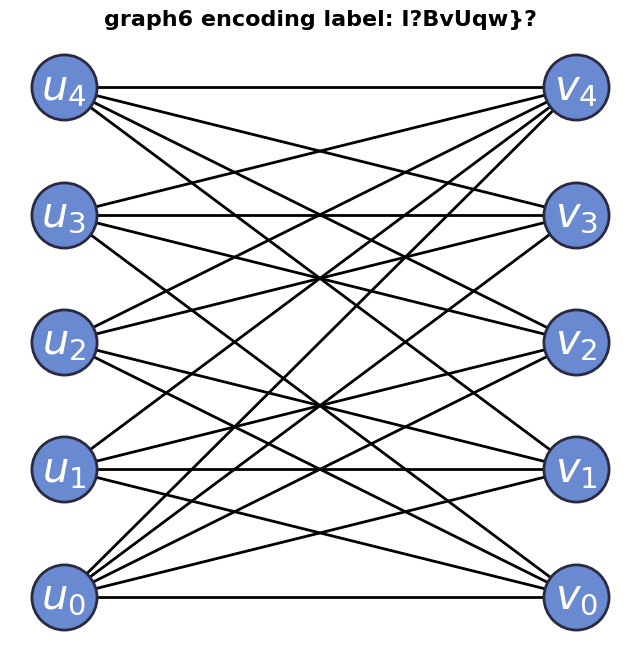

In [7]:
graphs = []
for graph in opt_graphs:
    byte_graph_encoding = graph.encode()
    decoded_graph = nx.from_graph6_bytes(byte_graph_encoding)
    graphs.append(decoded_graph)

for i, graph in enumerate(graphs):

    label = (
        nx.to_graph6_bytes(graph, header=False)
        .decode("utf-8")
        .replace("\n", "")
        .replace("\r", "")
    )
    
    if nx.is_bipartite(graph):
        u_set, v_set = nx.bipartite.sets(graph)
        
        labels = {}
        for i, node in enumerate(sorted(u_set)):
            labels[node] = f"$u_{{{i}}}$"
        for i, node in enumerate(sorted(v_set)):
            labels[node] = f"$v_{{{i}}}$"
        
        plt.figure(figsize=(8, 8))
        
        nx.draw_networkx(
            graph,
            pos=nx.bipartite_layout(graph, u_set),
            labels=labels,
            node_color="#698ad1",
            edgecolors="#292a40",
            linewidths=2,
            node_size=2200,
            width=2,
            font_color="white",
            font_size=30
        )

        plt.title(f"graph6 encoding label: {label}", fontweight='bold', fontsize=16)
        plt.axis("off")
        plt.show()

    else:
        plt.figure(figsize=(8, 8))
        
        labels = {}
        for i, node in enumerate(graph.nodes()):
            labels[node] = f"$v_{{{i}}}$"

        nx.draw(
            graph,
            labels=labels,
            node_color="#698ad1",
            edgecolors="#292a40",
            linewidths=2,
            node_size=2200,
            width=2,
            font_color="white",
            font_size=30
        )
        plt.title(f"graph6 encoding label: {label}", fontweight='bold', fontsize=16)
        plt.axis("off")
        plt.show()


In [8]:
data = []
for graph6_str in opt_graphs:
    graph = nx.from_graph6_bytes(graph6_str.encode())
    
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    is_bipartite = nx.is_bipartite(graph)
    is_cubic = all(degree == 3 for _, degree in graph.degree())
    is_triangle_free = (
        all(nx.triangles(graph, node) == 0 for node in graph.nodes())
        if not nx.is_bipartite(graph)
        else True
    )
    gpn_num = gpn(graph)
    
    data.append([
        graph6_str,
        num_nodes,
        num_edges,
        is_triangle_free,
        is_bipartite,
        is_cubic,
        gpn_num
    ])

report_opt_df = pd.DataFrame(
    data,
    columns=["graph6_id", "num_nodes", "num_edges",  "is_triangle_free", "is_bipartite", "is_cubic", "gpn_num"]
)

report_opt_df


,graph6_id,num_nodes,num_edges,is_triangle_free,is_bipartite,is_cubic,gpn_num
0,@,1,0,True,True,False,1
1,A_,2,1,True,True,False,3
2,BW,3,2,True,True,False,6
3,Bw,3,3,False,False,False,6
4,C],4,4,True,True,False,12
5,DFw,5,6,True,True,False,20
6,EFz_,6,9,True,True,True,33
7,F?zv_,7,11,True,True,False,49
8,F?~v_,7,12,True,True,False,49
9,G?zVf_,8,14,True,True,False,74


In [9]:
map_col = ['is_bipartite', 'is_cubic', 'is_triangle_free']
report_opt_df[map_col] = report_opt_df[map_col].map(lambda col: 'ja' if col else 'ne')
report_opt_df
tex_code = report_opt_df.to_latex(index=False)
print(tex_code)


\begin{tabular}{lrrlllr}
\toprule
graph6_id & num_nodes & num_edges & is_triangle_free & is_bipartite & is_cubic & gpn_num \\
\midrule
@ & 1 & 0 & ja & ja & ne & 1 \\
A_ & 2 & 1 & ja & ja & ne & 3 \\
BW & 3 & 2 & ja & ja & ne & 6 \\
Bw & 3 & 3 & ne & ne & ne & 6 \\
C] & 4 & 4 & ja & ja & ne & 12 \\
DFw & 5 & 6 & ja & ja & ne & 20 \\
EFz_ & 6 & 9 & ja & ja & ja & 33 \\
F?zv_ & 7 & 11 & ja & ja & ne & 49 \\
F?~v_ & 7 & 12 & ja & ja & ne & 49 \\
G?zVf_ & 8 & 14 & ja & ja & ne & 74 \\
G?zvf_ & 8 & 15 & ja & ja & ne & 74 \\
H?BvUrw & 9 & 17 & ja & ja & ne & 105 \\
H?BvVrw & 9 & 18 & ja & ja & ne & 105 \\
H?ovfbo & 9 & 16 & ja & ja & ne & 105 \\
I?BvUqw}? & 10 & 21 & ja & ja & ne & 151 \\
\bottomrule
\end{tabular}

